# Imports y definicion de la función

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
import os
os.makedirs("figures", exist_ok=True)

plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.grid'] = True


# f(x,y) = arctan(x+y+1) - arctan(2 - (x+y)) + x^2

def f_numpy(v):
    x, y = v
    s = x + y
    return np.arctan(s + 1) - np.arctan(2 - s) + x**2


def grad_numpy(v):
    x, y = v
    s = x + y
    df_ds = 1/(1+(s+1)**2) + 1/(1+(2-s)**2)   # derivada w.r.t (x+y)
    dfdx = df_ds + 2*x
    dfdy = df_ds
    return np.array([dfdx, dfdy])


def hessian_numpy(v):
    x, y = v
    s = x + y
    term1 = -2*(s+1) / (1+(s+1)**2)**2
    term2 = 2*(2-s) / (1+(2-s)**2)**2
    d2_ds2 = term1 + term2

    Hxx = d2_ds2 + 2
    Hxy = d2_ds2
    Hyx = d2_ds2
    Hyy = d2_ds2
    
    return np.array([[Hxx, Hxy], [Hyx, Hyy]])



# Gradient descent with backtracking line search (custom)

In [51]:
def gradient_descent_backtracking(x0, max_iter=200, alpha0=1.0, beta=0.5, c=1e-4):
    x = np.array(x0, dtype=float)
    trajectory = [x.copy()]
    
    for k in range(max_iter):
        g = grad_numpy(x)
        g_norm2 = np.dot(g, g)
        if g_norm2 < 1e-12:
            break
        
        t = alpha0
        # backtracking
        while f_numpy(x - t*g) > f_numpy(x) - c*t*g_norm2:
            t *= beta
            if t < 1e-10:
                return {
                    "x_final": x,
                    "f_final": f_numpy(x),
                    "nit": k,
                    "grad_norm": np.linalg.norm(g),
                    "success": False,
                    "trajectory": np.array(trajectory)
                }
        
        x = x - t*g
        trajectory.append(x.copy())
    
    return {
        "x_final": x,
        "f_final": f_numpy(x),
        "nit": k+1,
        "grad_norm": np.linalg.norm(grad_numpy(x)),
        "success": True,
        "trajectory": np.array(trajectory)
    }


# Newton(SciPy, Newton-CG) 

In [52]:
def run_newton(x0):
    trajectory = []
    
    def callback(xk):
        trajectory.append(np.copy(xk))
    
    res = minimize(f_numpy, x0, method="Newton-CG",
                   jac=grad_numpy, hess=hessian_numpy,
                   callback=callback,
                   options={'maxiter': 200})
    
    return {
        "x_final": res.x,
        "f_final": res.fun,
        "nit": res.nit,
        "grad_norm": np.linalg.norm(grad_numpy(res.x)),
        "success": res.success,
        "trajectory": np.array(trajectory)
    }


# BFGS(SciPy)

In [53]:
def run_bfgs(x0):
    trajectory = []
    
    def callback(xk):
        trajectory.append(np.copy(xk))
    
    res = minimize(f_numpy, x0, method="BFGS",
                   jac=grad_numpy, callback=callback,
                   options={'maxiter': 200})
    
    return {
        "x_final": res.x,
        "f_final": res.fun,
        "nit": res.nit,
        "grad_norm": np.linalg.norm(grad_numpy(res.x)),
        "success": res.success,
        "trajectory": np.array(trajectory)
    }


# Quick Experiment

In [54]:
points_test = [(10*i, 10*j) 
               for i in range(-3,4) 
               for j in range(-3,4)]

results_test = []

for p in points_test:
    out = run_bfgs(p)
    results_test.append({
        "x0": p,
        "xf": out["x_final"],
        "f": out["f_final"],
        "grad_norm": out["grad_norm"],
        "nit": out["nit"],
        "success": out["success"]
    })

df_test = pd.DataFrame(results_test)
df_test.head()
df_test.to_csv("results_test.csv", index=False)



# Full Experiment

In [55]:
points_full = [(10*i, 10*j) for i in range(-10,11) for j in range(-10,11)]

def run_full_experiment(method):
    rows = []
    for p in points_full:
        if method == "GD":
            out = gradient_descent_backtracking(p)
        elif method == "BFGS":
            out = run_bfgs(p)
        elif method == "Newton":
            out = run_newton(p)

        rows.append({
            "x0": p,
            "xf": out["x_final"],
            "f": out["f_final"],
            "nit": out["nit"],
            "grad_norm": out["grad_norm"],
            "success": out["success"]
        })
    
    return pd.DataFrame(rows)

df_gd = run_full_experiment("GD")
df_bfgs = run_full_experiment("BFGS")
df_newton = run_full_experiment("Newton")

df_gd.to_csv("results_gd.csv", index=False)
df_bfgs.to_csv("results_bfgs.csv", index=False)
df_newton.to_csv("results_newton.csv", index=False)


# 3D Charts

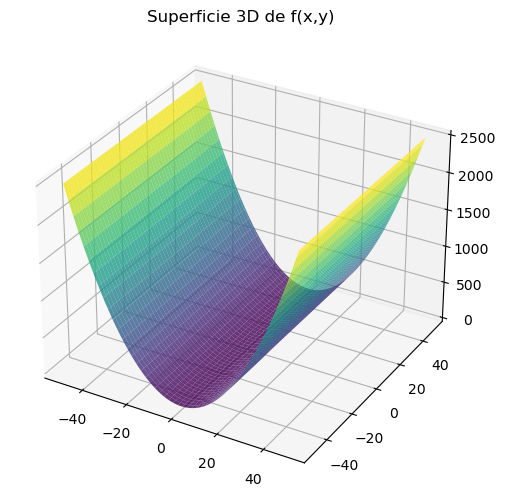

In [56]:
X = np.linspace(-50, 50, 100)
Y = np.linspace(-50, 50, 100)
XX, YY = np.meshgrid(X, Y)
ZZ = np.vectorize(lambda x,y: f_numpy([x,y]))(XX, YY)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(XX, YY, ZZ, cmap="viridis", alpha=0.8)
ax.set_title("Superficie 3D de f(x,y)")
plt.show()


# Graphics — Contours + example path

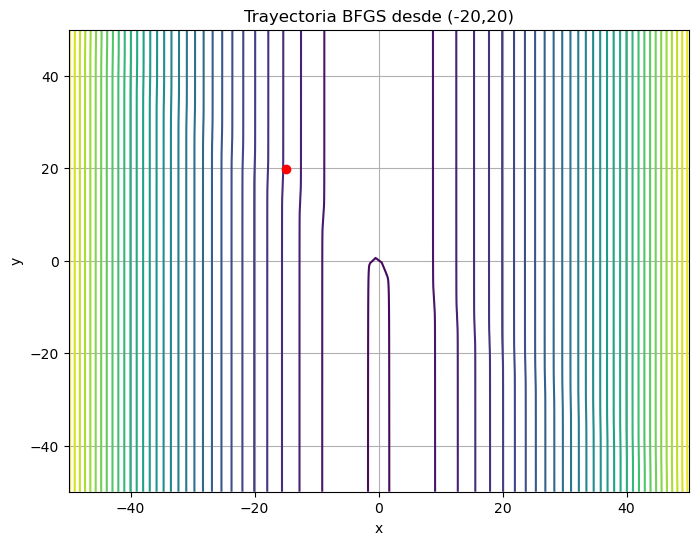

<Figure size 800x600 with 0 Axes>

In [57]:
plt.contour(XX, YY, ZZ, levels=40)

out = run_bfgs([-20,20])
traj = out["trajectory"]

# Filtrar para no dibujar puntos que se salen del rango [-20,20]
traj_plot = []
for (xk, yk) in traj:
    if -20 <= xk <= 20 and -20 <= yk <= 20:
        traj_plot.append([xk, yk])
    else:
        break  # dejamos de graficar cuando se sale del cuadro

traj_plot = np.array(traj_plot)

# Graficar solo la parte válida
plt.plot(traj_plot[:,0], traj_plot[:,1], '-o', color='red')

plt.title("Trayectoria BFGS desde (-20,20)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

plt.savefig("figures/trayectoria_bfgs.png")
